<a href="https://colab.research.google.com/github/ecesoyseven/credit_risk_prediction/blob/main/credit_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       140
           1       0.67      0.53      0.59        60

    accuracy                           0.78       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200



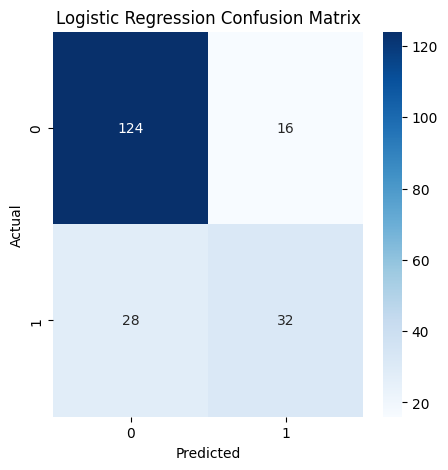


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       140
           1       0.38      0.37      0.37        60

    accuracy                           0.63       200
   macro avg       0.56      0.55      0.56       200
weighted avg       0.63      0.63      0.63       200



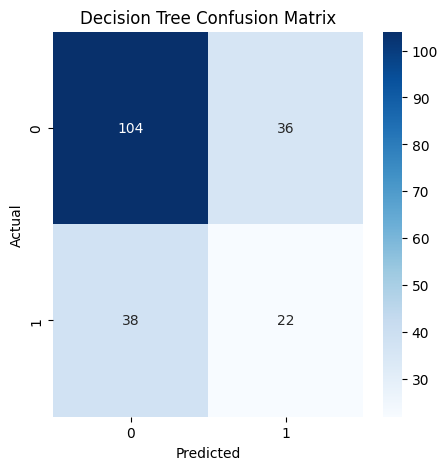


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       140
           1       0.61      0.38      0.47        60

    accuracy                           0.74       200
   macro avg       0.69      0.64      0.65       200
weighted avg       0.72      0.74      0.72       200



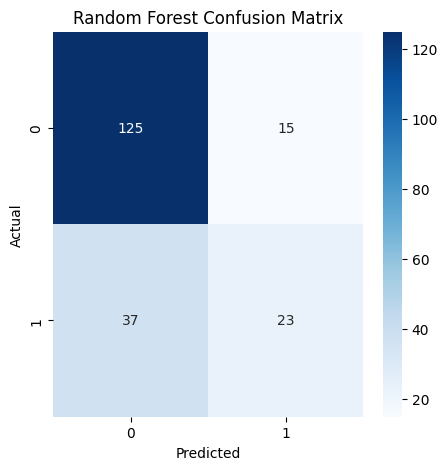

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:55:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       140
           1       0.59      0.48      0.53        60

    accuracy                           0.74       200
   macro avg       0.69      0.67      0.68       200
weighted avg       0.73      0.74      0.74       200



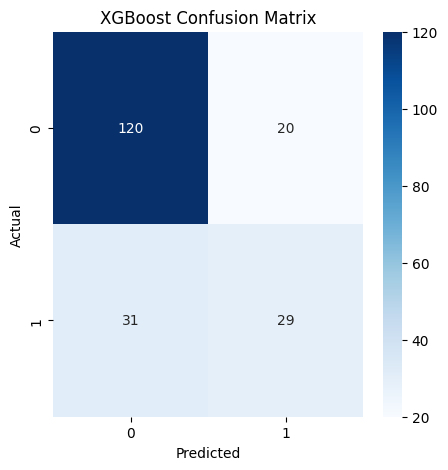


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression     0.780   0.666667  0.533333  0.592593
1        Decision Tree     0.630   0.379310  0.366667  0.372881
2        Random Forest     0.740   0.605263  0.383333  0.469388
3              XGBoost     0.745   0.591837  0.483333  0.532110


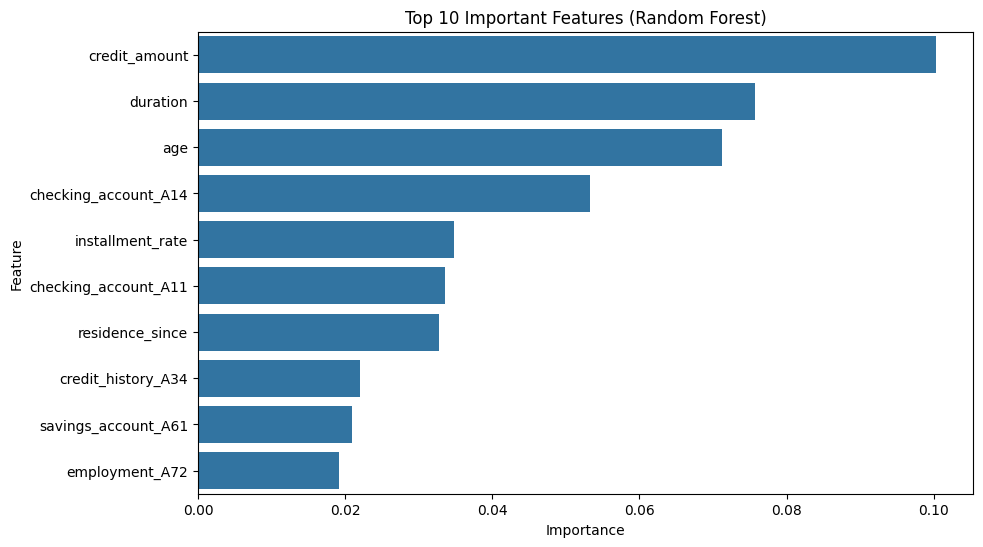

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:55:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['best_model.pkl']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
column_names = [
    'checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings_account', 'employment', 'installment_rate', 'personal_status',
    'other_debtors', 'residence_since', 'property', 'age', 'other_installment_plans',
    'housing', 'existing_credits', 'job', 'people_liable', 'telephone', 'foreign_worker', 'risk'
]
data = pd.read_csv(url, delimiter=' ', header=None, names=column_names)

data['risk'] = data['risk'].map({1: 0, 2: 1})

X = data.drop('risk', axis=1)
y = data['risk']

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = []
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf_pipeline.fit(X_train, y_train)

feature_names = numerical_cols.tolist()
cat_features = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names.extend(cat_features)

importances = rf_pipeline.named_steps['classifier'].feature_importances_
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features (Random Forest)')
plt.show()

import joblib
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])
best_model.fit(X_train, y_train)
joblib.dump(best_model, 'best_model.pkl')

In [8]:
import streamlit as st
import pandas as pd
import joblib

model = joblib.load('best_model.pkl')

st.title('Credit Risk Prediction')
st.write('This app predicts whether a credit application is low or high risk.')

st.sidebar.header('Customer Information')

def user_input_features():
    checking_account = st.sidebar.selectbox('Checking Account', ['A11', 'A12', 'A13', 'A14'])
    duration = st.sidebar.slider('Duration (months)', 4, 72, 24)
    credit_history = st.sidebar.selectbox('Credit History', ['A30', 'A31', 'A32', 'A33', 'A34'])
    purpose = st.sidebar.selectbox('Purpose', ['A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A410'])
    credit_amount = st.sidebar.slider('Credit Amount', 250, 18424, 5000)

    data = {
        'checking_account': checking_account,
        'duration': duration,
        'credit_history': credit_history,
        'purpose': purpose,
        'credit_amount': credit_amount,
        'savings_account': 'A61',
        'employment': 'A71',
        'installment_rate': 2,
        'personal_status': 'A93',
        'other_debtors': 'A101',
        'residence_since': 2,
        'property': 'A121',
        'age': 35,
        'other_installment_plans': 'A143',
        'housing': 'A152',
        'existing_credits': 1,
        'job': 'A171',
        'people_liable': 1,
        'telephone': 'A191',
        'foreign_worker': 'A201'
    }
    features = pd.DataFrame(data, index=[0])
    return features

input_df = user_input_features()

st.subheader('Customer Details')
st.write(input_df)

prediction = model.predict(input_df)
prediction_proba = model.predict_proba(input_df)

st.subheader('Prediction')
risk_labels = ['High Risk', 'Low Risk']
st.write(risk_labels[prediction[0]])

st.subheader('Prediction Probability')
st.write(f"High Risk: {prediction_proba[0][0]:.2f}")
st.write(f"Low Risk: {prediction_proba[0][1]:.2f}")

st.subheader('Model Information')
st.write('This model uses XGBoost algorithm trained on German Credit dataset.')
st.write('The model predicts whether a credit application is likely to be:')
st.write('- High Risk (potential default)')
st.write('- Low Risk (likely to repay)')

2025-05-25 17:56:28.117 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 17:56:28.122 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 17:56:28.126 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 17:56:28.130 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 17:56:28.134 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 17:56:28.139 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 17:56:28.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 17:56:28.146 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar